In [130]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import mplhep as hep
from scipy.optimize import curve_fit
import pandas as pd

plt.style.use(hep.style.ROOT)

### user defined

In [136]:
### Variables used in software
baseline = 0
#16/12/2022 14:10
import time
#help(time)
starttime=time.struct_time((2022, 12, 16, 14, 10,0,-1,-1,-1))

renameChannels=False

In [137]:
with open('Run10_list.txt') as f:
    lines = f.read().split('\n')
tags = None
channels =[]
din={"timestamp":[], "trigID":[]}
#din.update({f"timestamp_{unit}":[] for unit in "year month day hour minute"})
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue
    #first line after comments
    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue
    split = line.split()
    
    if len(split)== 6:
        timestamp_us=float(split[0])
        din['timestamp'].append(timestamp_us)
        trigID=int(split[1])
        din['trigID'].append(trigID)
    
    channel, LG, HG = split[-3:]
    if channel not in channels:
        din[f"Ch_{channel}_LG"] = []
        din[f"Ch_{channel}_HG"] = []
        channels.append(channel)
    din[f"Ch_{channel}_LG"].append(float(LG)-baseline)
    din[f"Ch_{channel}_HG"].append(float(HG)-baseline)
df = pd.DataFrame(din)


if renameChannels:
    new_channels=[]
    for ch in reversed(channels):
        newname=str(int(ch)+1)
        if len(newname)==1:
            newname="0"+newname
        df = df.rename({f"Ch_{ch}_LG":f"Ch_{newname}_LG", f"Ch_{ch}_HG":f"Ch_{newname}_HG"}, axis=1)
        new_channels.append(newname)
    channels=list(reversed(new_channels))
    

print(f"Done! Total events: {len(df)}")
print(f"channels in df are:  {channels}")
channels.remove("00")

Done! Total events: 26507
channels in df are:  ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


In [138]:
def Landau(x, normalization,location,stdev):
    #print(type(x))
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def LandauPlusGauss(x, normalization,location,stdev, a, mu, sigma):
    u=(x-location)*3.591/stdev/2.355
    renormalization = 1.64872*normalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)+a*np.exp(-(x-mu)**2/(2*sigma**2))

def Gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

30.10850069439133
30.11955887328966
24.808686265247793
26.655932500155295
27.901761942378243
20.937764084198957
30.69973734998129
29.34019904335455
28.639643745575757
25.511389022483744
30.751265949573497
28.69994964640312
26.774165044463736
66.313433184516
31.981356073062404


/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_32865/4211322853.py:5: RuntimeWarning: overflow encountered in exp
  return renormalization * np.exp(-u/2 - np.exp(-u)/2)


20
20.5


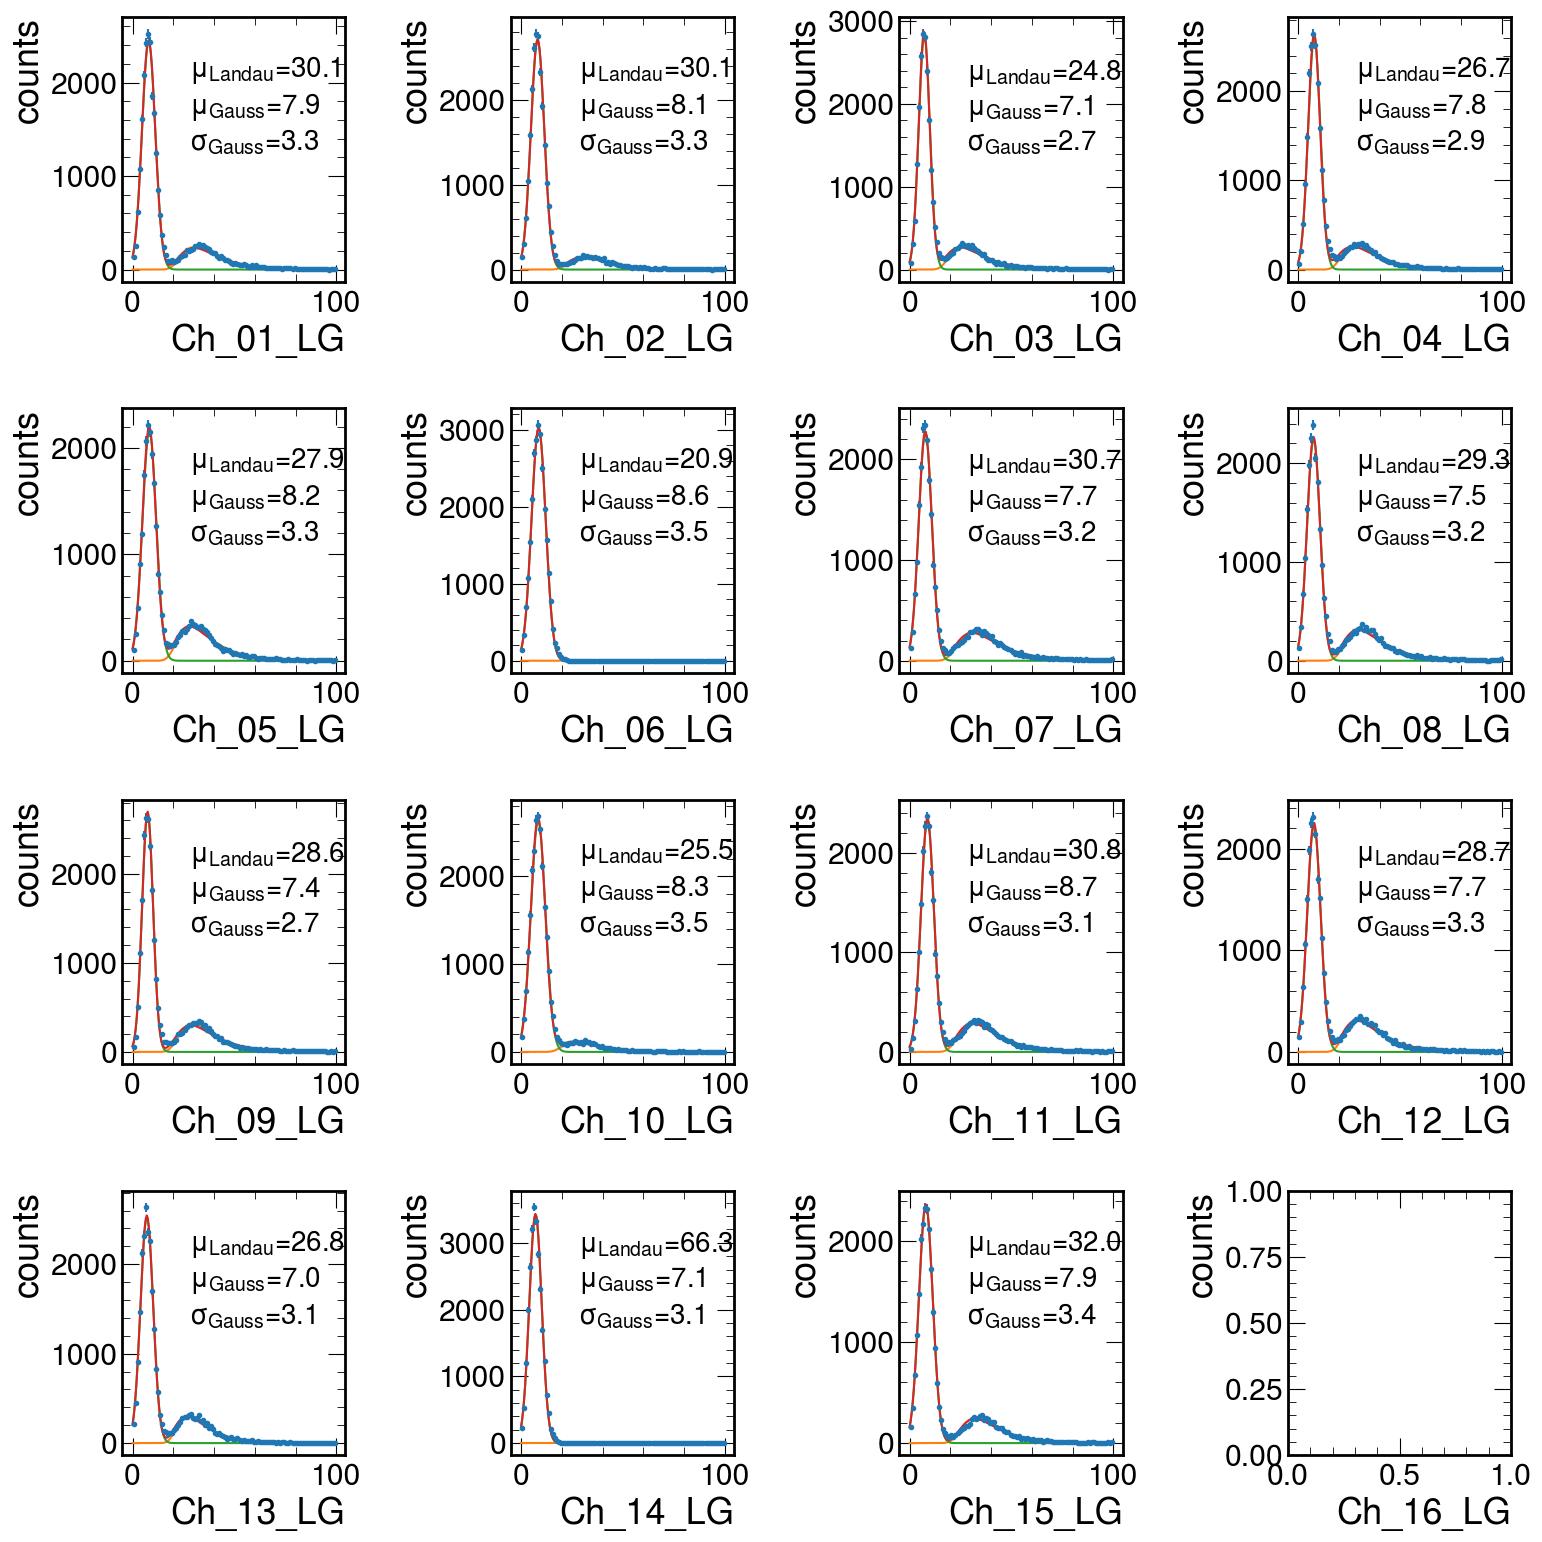

606.7980808273186
594.6267886369014
498.4550664843269
538.186794259307
538.1519500019256
647.9598426949708
602.9802956524499
622.016194891906
458.0319473215446
611.9258997845051
574.912517836558
567.9808864174861
656.3367020140688
0
5.0


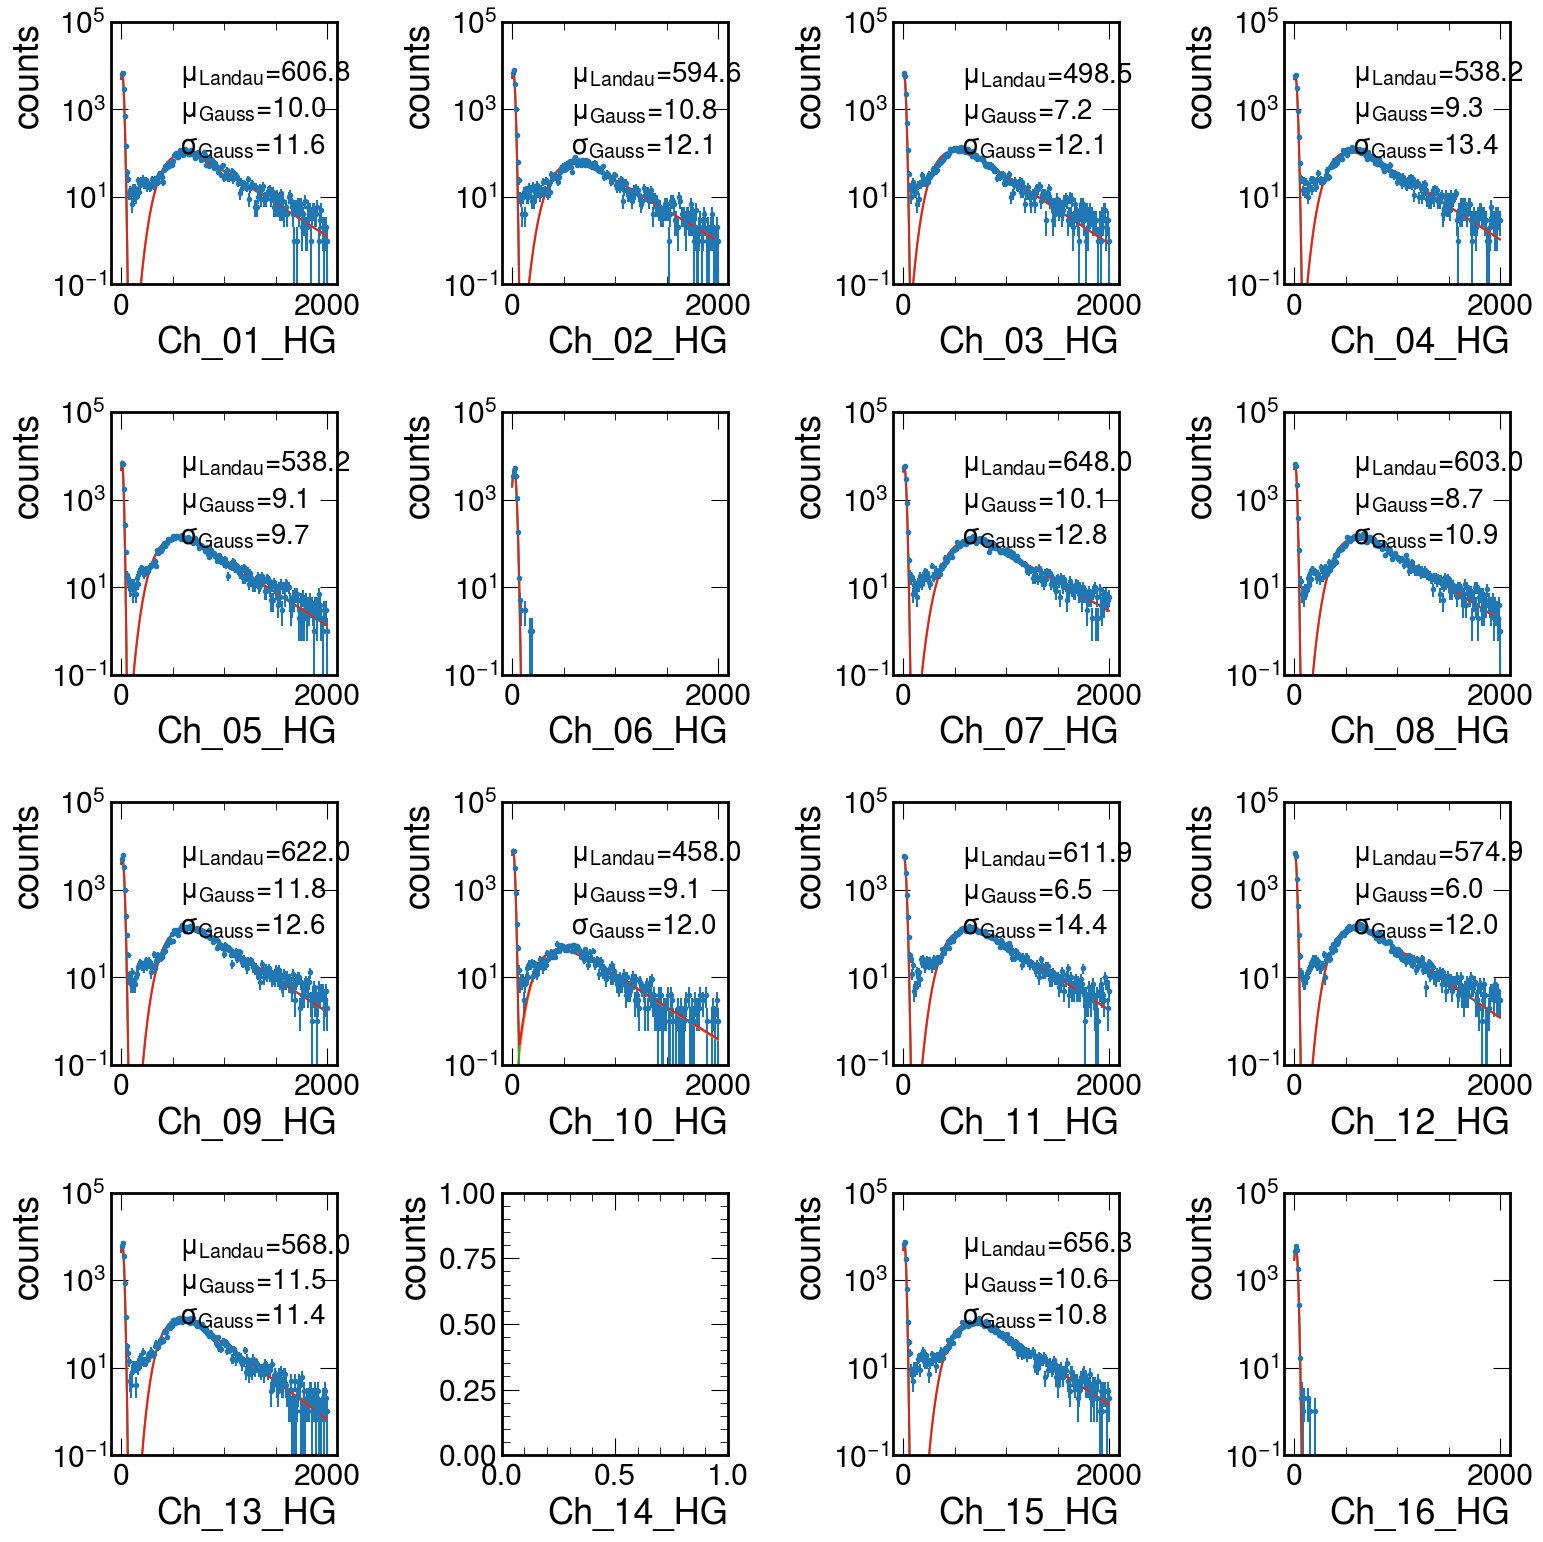

1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
20
20.5


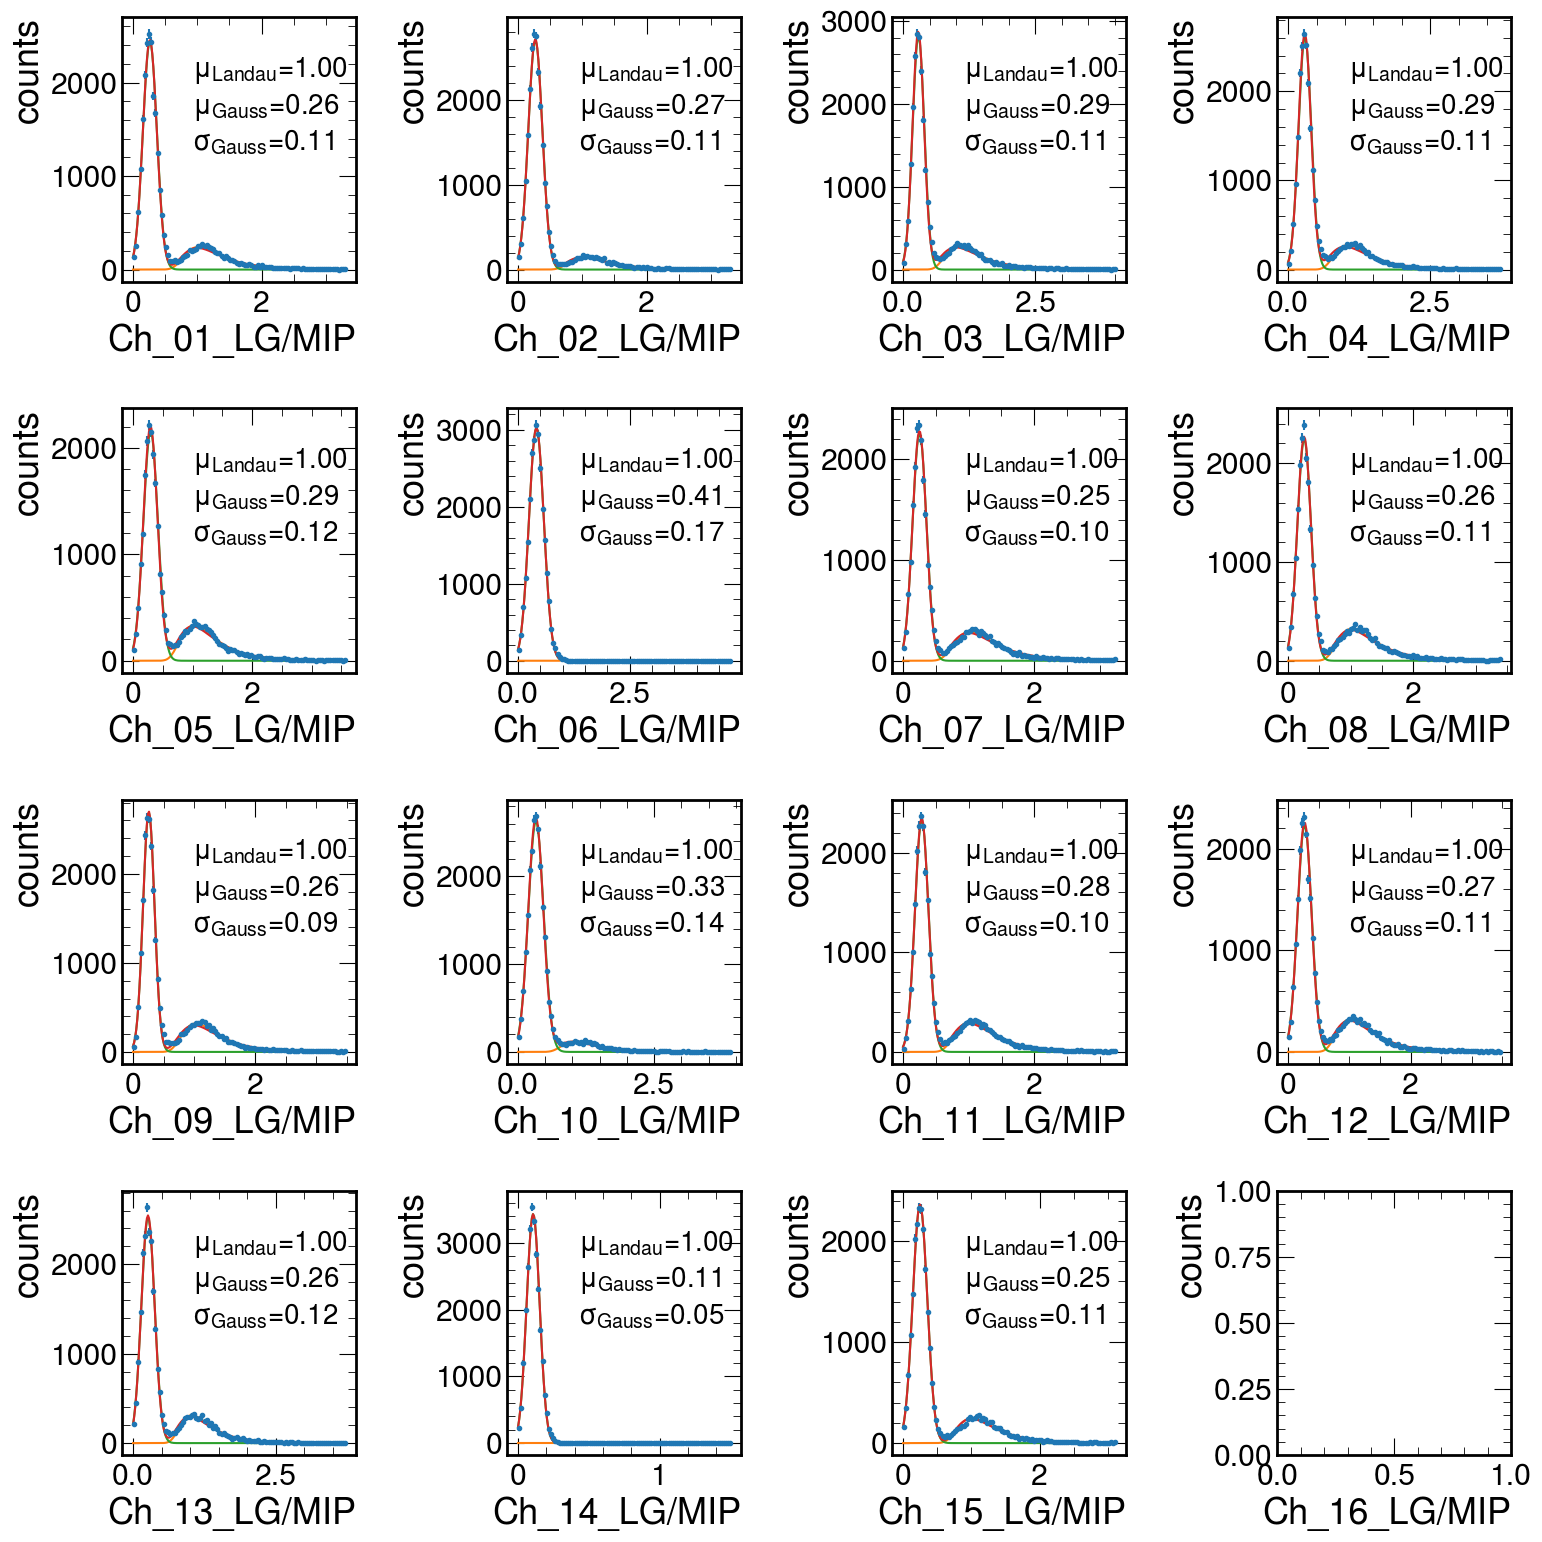

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0
5.0


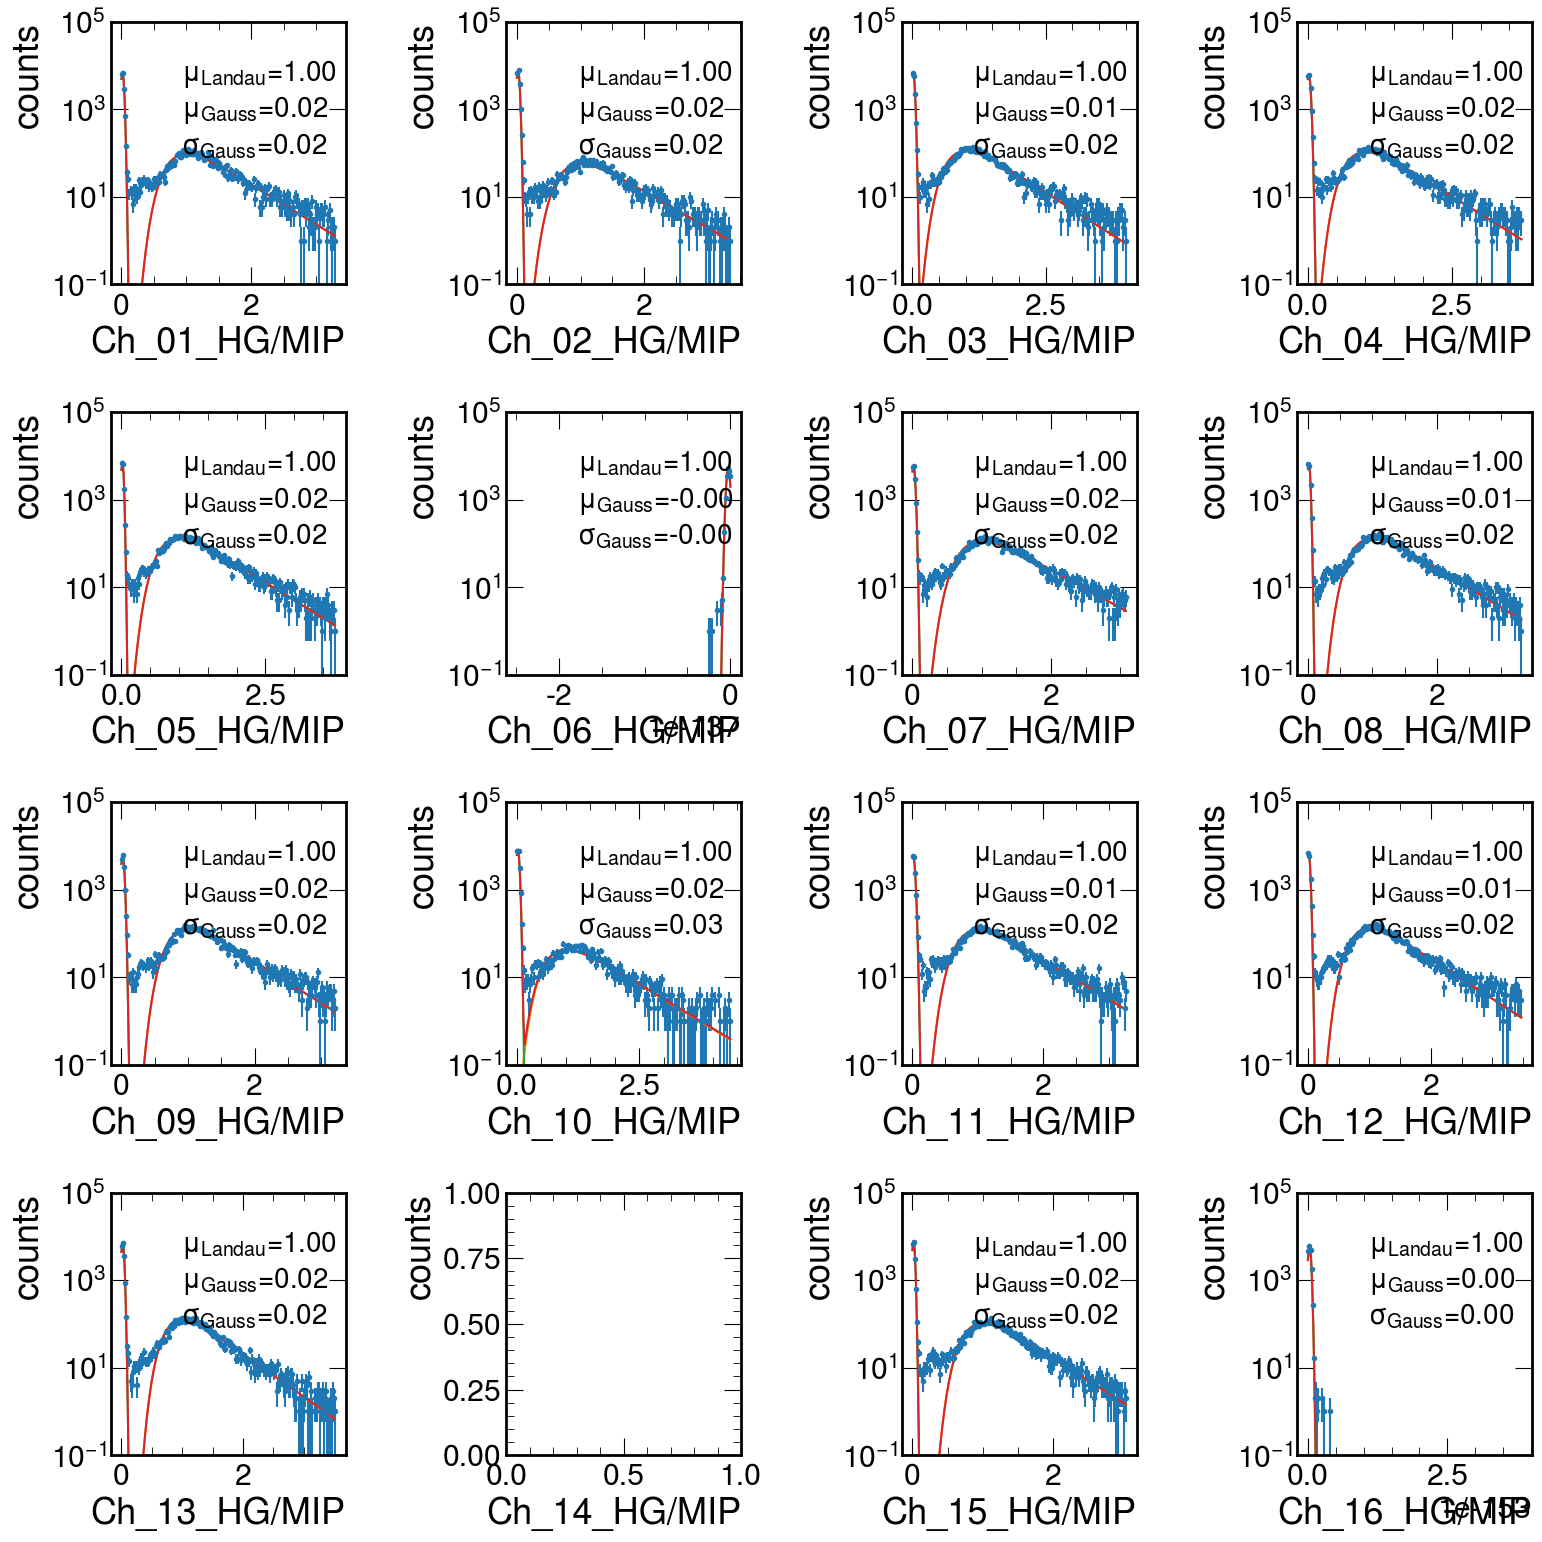

In [183]:
for useMIP in False, True:
    for gain in "LG HG".split():
        fig, axs=plt.subplots(4,4, figsize=(16, 16))
        for i in range(len(channels)):

            ch = channels[i]
            plt.sca(axs[i//4][i%4])
            hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}"), bins=100 if gain== "LG" else 200, 
                                  range=(0,100) if gain == "LG" else (0, 2000))
            xlabel=f"Ch_{ch}_{gain}"
            if useMIP:
                xlabel+='/MIP'
            
            plt.xlabel(xlabel)
            plt.ylabel("counts")

            bin_centers=(x[1:]+x[:-1])/2

            from scipy.optimize import curve_fit
            if gain=="LG":
                start,stop=int(20/(x[1]-x[0])),None
            else :
                start,stop=int(100/(x[1]-x[0])),None
            p0=[1000, 30, 10]

            
            dhist=np.sqrt(hist)+(hist==0)
            try:
                coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                     sigma=dhist[start:stop])

                from scipy.stats import chi2
                #chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist[start:stop]**2)
                #ndof = len(bin_centers[start:stop])-len(coeff)
                #print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
                x=np.linspace(0, max(bin_centers), 200)
                mu=coeff[1]


                if gain=="LG":
                    start, stop = 0, int(20/(bin_centers[1]-bin_centers[0]))
                else :
                    start, stop = 0, int(400/(bin_centers[1]-bin_centers[0]))
                coeff_g, var_matrix = curve_fit(Gauss, bin_centers[start:stop], hist[start:stop], p0=[10000,10,15],
                                         sigma=dhist[start:stop])


                coeff_lg, var_matrix = curve_fit(LandauPlusGauss, bin_centers, hist, p0=list(coeff)+list(coeff_g),
                                         sigma=dhist)

                mu=coeff_lg[1]
                mu_g=coeff_lg[4]
                sigma_g=abs(coeff_lg[5])
                
                scale=1
                if useMIP:
                    scale=1/mu
                plt.errorbar(bin_centers*scale, hist, np.sqrt(hist), linestyle='', marker='o', label='data', markersize=3)
                curve = plt.plot(x*scale, Landau(x,*coeff), label=f"Landau")
                curve = plt.plot(x*scale, Gauss(x,*coeff_g), label=f"Gauss")
                curve = plt.plot(x*scale, LandauPlusGauss(x,*coeff_lg), label=f"Landau+Gauss")

                #plt.legend(fontsize=12)
                
                if abs(mu*scale) < 1e5:
                    print(mu*scale)
                    if useMIP:
                        plt.text(0.30, 0.5, f"$\mu_{{\\rm Landau}}$={mu*scale:.2f}\n$\mu_{{\\rm Gauss}}$={mu_g*scale:.2f}\n$\\sigma_{{\\rm Gauss}}$={sigma_g*scale:.2f}", transform=plt.gca().transAxes, fontsize=20)
                    else:
                        plt.text(0.30, 0.5, f"$\mu_{{\\rm Landau}}$={mu*scale:.1f}\n$\mu_{{\\rm Gauss}}$={mu_g*scale:.1f}\n$\\sigma_{{\\rm Gauss}}$={sigma_g*scale:.1f}", transform=plt.gca().transAxes, fontsize=20)
                
                if gain == "HG":
                    plt.yscale("log")
                    plt.ylim(0.1, 1e5)
                MIP[(ch,gain)]=mu

            except RuntimeError:
                pass
        plt.tight_layout()
        print(start)
        print(bin_centers[start])
        plt.show()

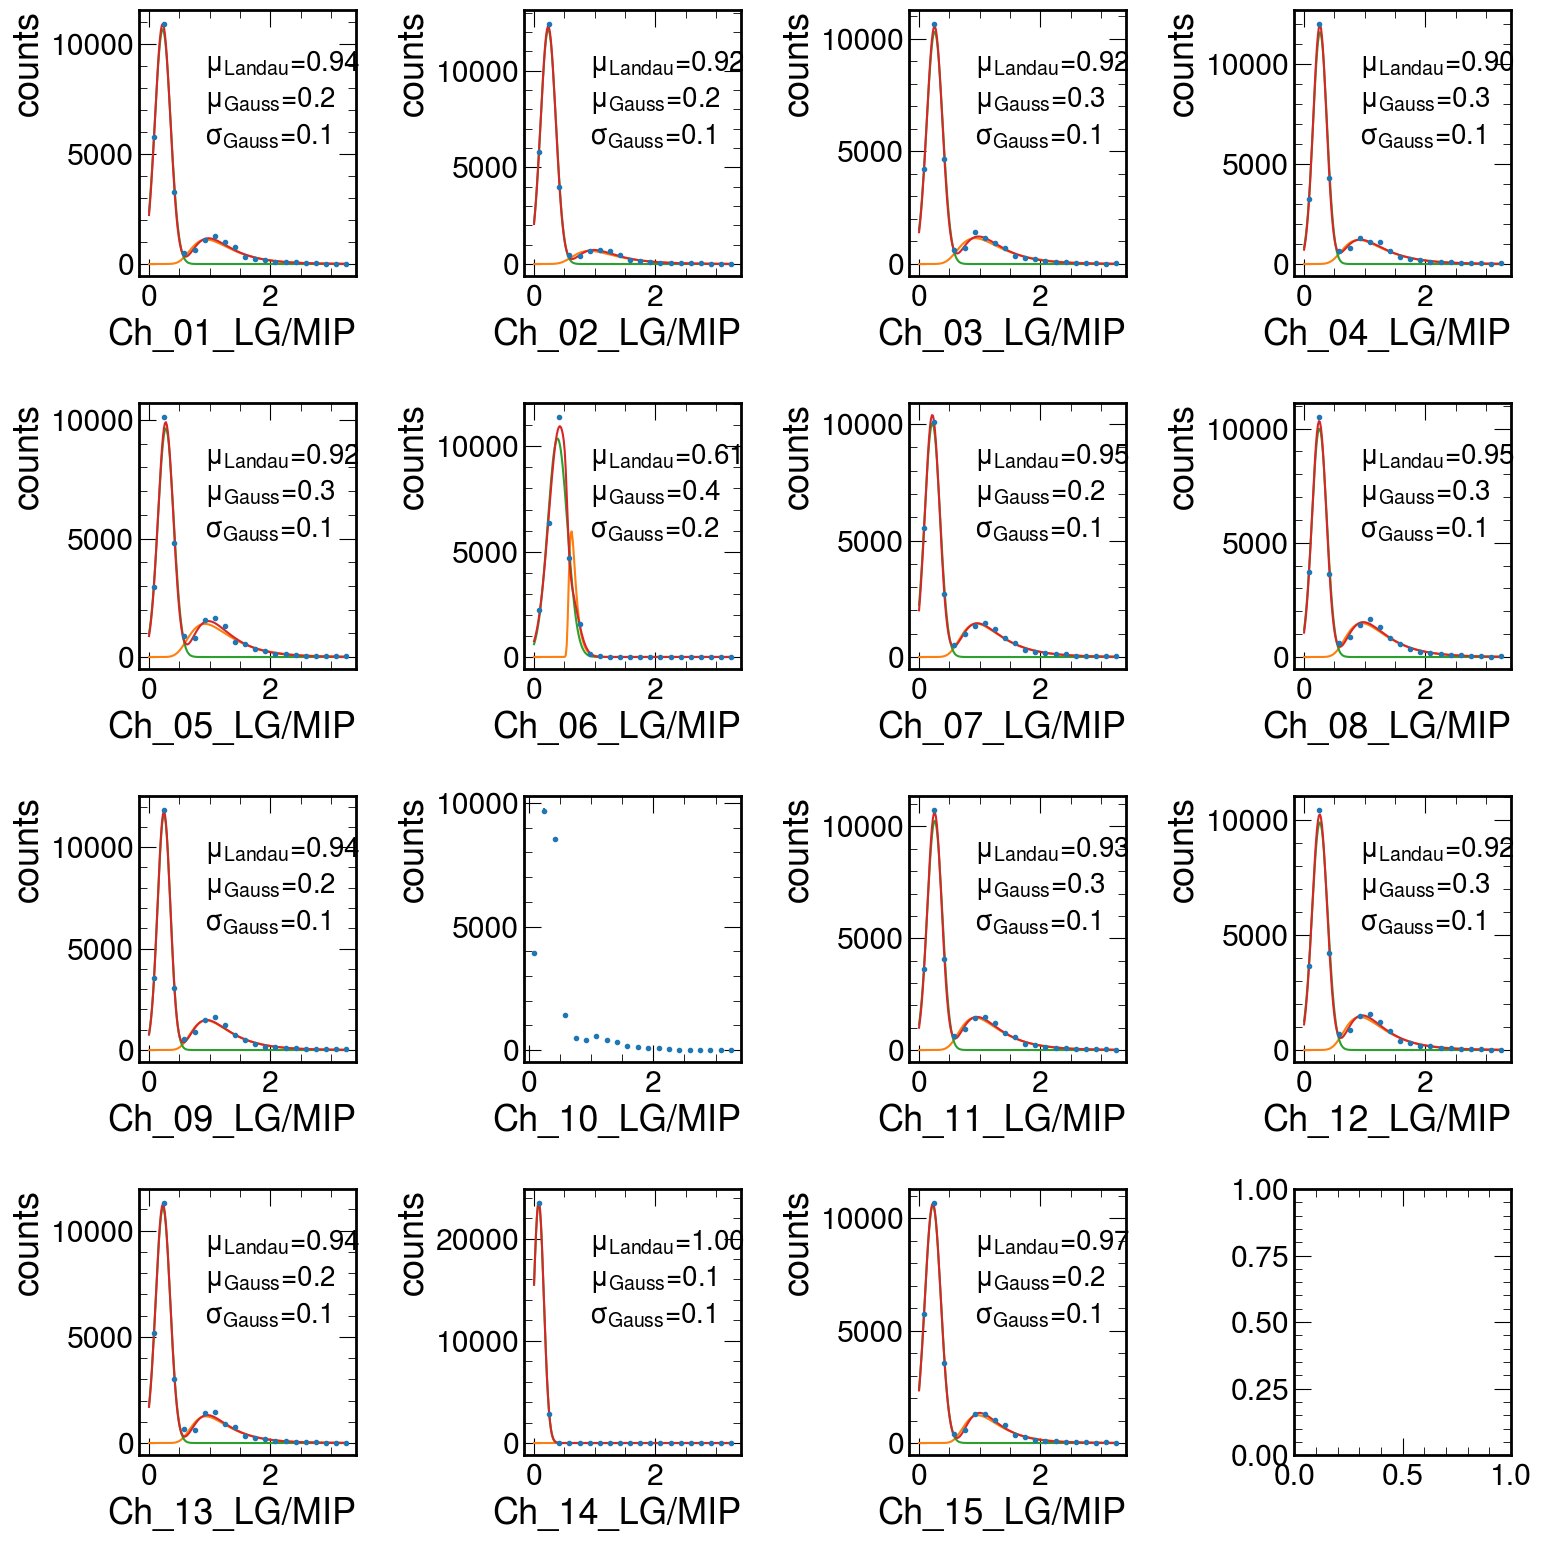

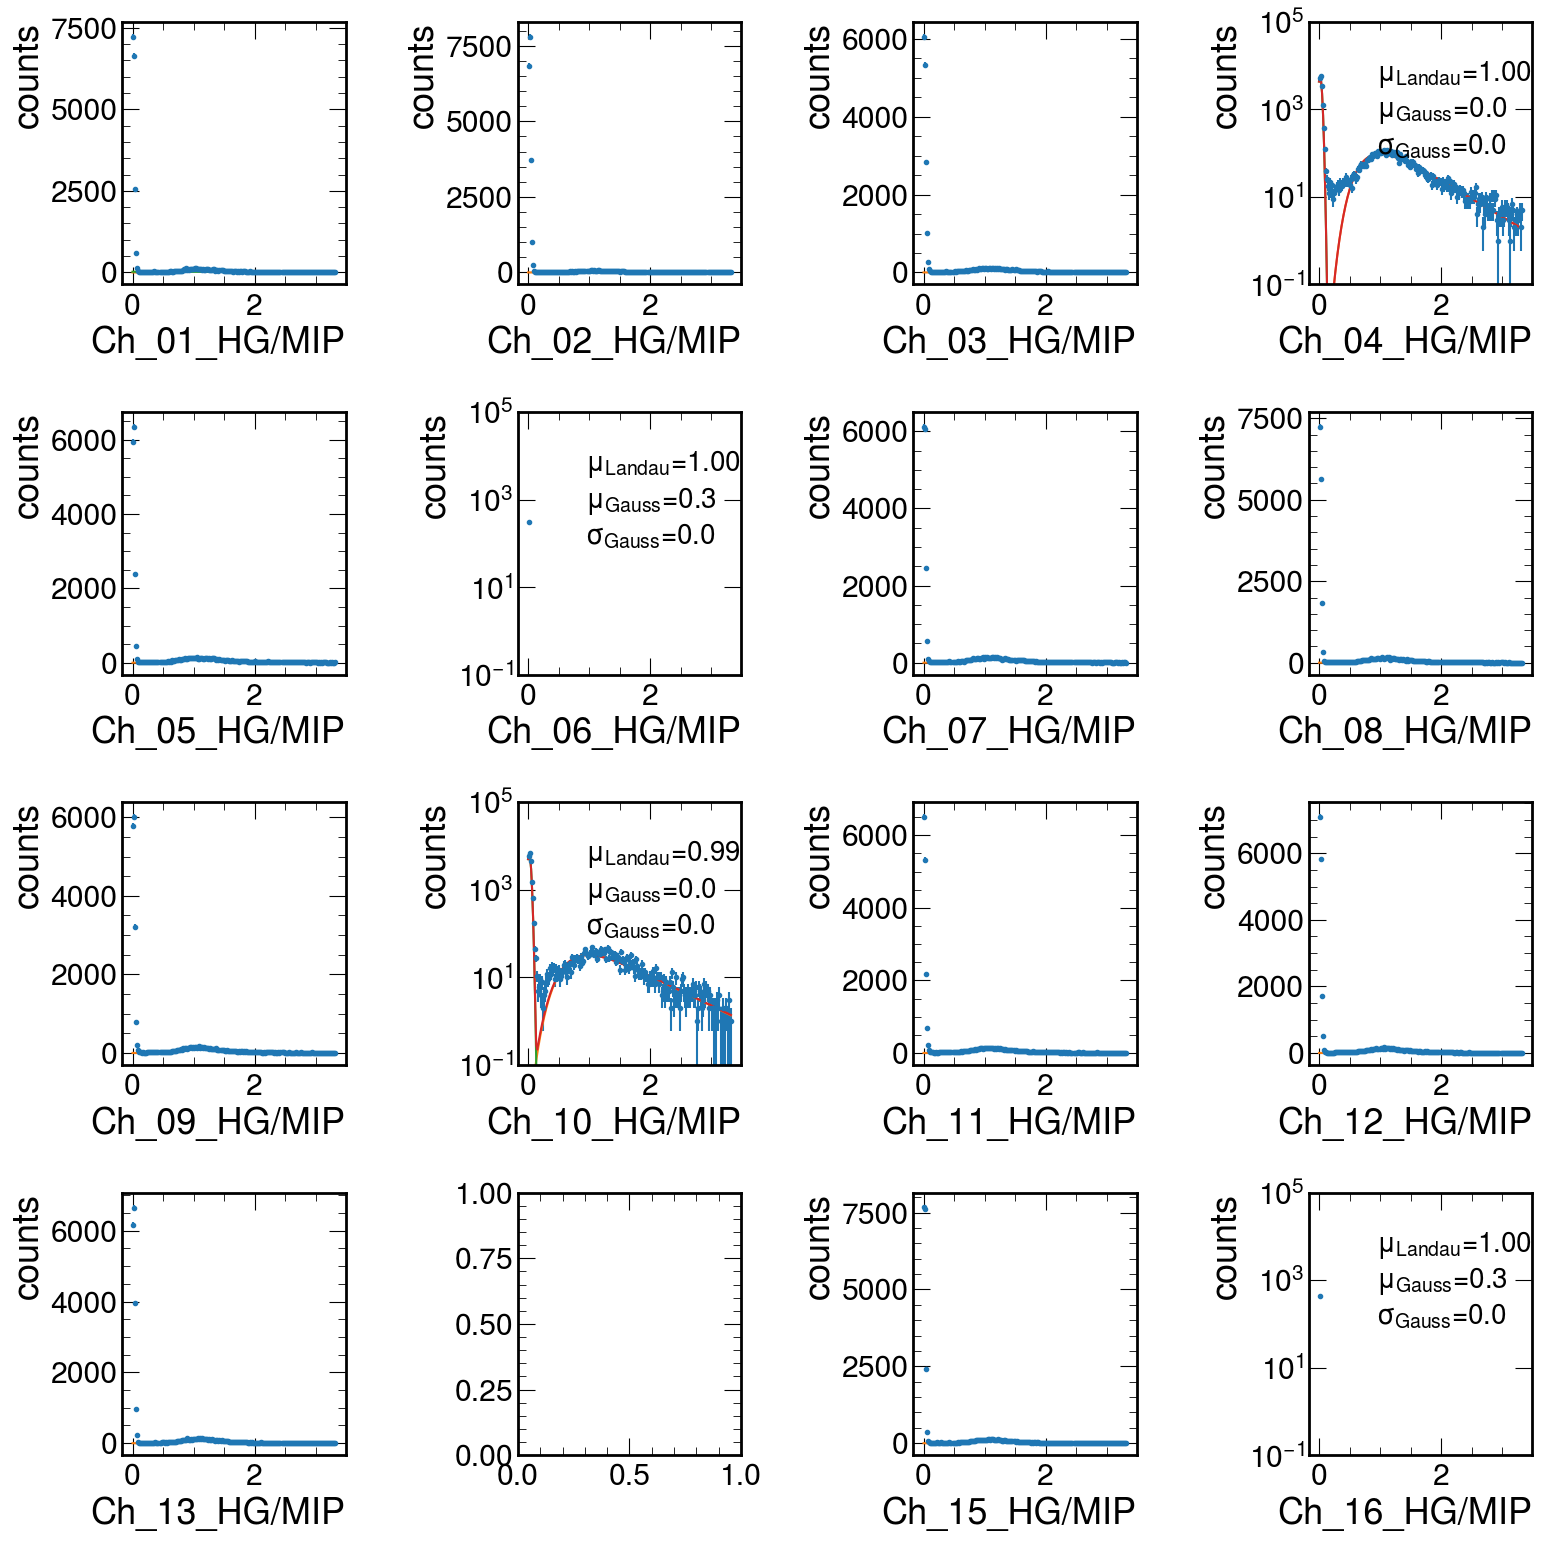

In [171]:
for gain in "LG HG".split():
    fig, axs=plt.subplots(4,4, figsize=(16, 16))
    for i in range(len(channels)):

            
        ch = channels[i]
        if (ch,gain) not in MIP:
            continue
        plt.sca(axs[i//4][i%4])
        hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}/{MIP[(ch,gain)]}"), bins=20 if gain== "LG" else 200, 
                              range=(0,100/30) if gain == "LG" else (0, 2000/600))
        plt.xlabel(f"Ch_{ch}_{gain}/MIP")
        plt.ylabel("counts")

        bin_centers=(x[1:]+x[:-1])/2

        from scipy.optimize import curve_fit
        if gain=="LG":
            start,stop=int(20/(x[1]-x[0])/30),None
        else :
            start,stop=int(100/(x[1]-x[0])/600),None
        p0=[1000, 1, 0.3]

        plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data', markersize=3)

        dhist=np.sqrt(hist)+(hist==0)
        try:
            coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                 sigma=dhist[start:stop])

            from scipy.stats import chi2
            #chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist[start:stop]**2)
            #ndof = len(bin_centers[start:stop])-len(coeff)
            #print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
            x=np.linspace(0, max(bin_centers), 200)
            mu=coeff[1]

            curve = plt.plot(x, Landau(x,*coeff), label=f"Landau")

            if gain=="LG":
                start, stop = 0, int(20/(bin_centers[1]-bin_centers[0])/30)
            else :
                start, stop = 0, int(400/(bin_centers[1]-bin_centers[0])/600)
            coeff_g, var_matrix = curve_fit(Gauss, bin_centers[start:stop], hist[start:stop], p0=[10000,0.3,0.05],
                                     sigma=dhist[start:stop])

            curve = plt.plot(x, Gauss(x,*coeff_g), label=f"Gauss")

            coeff_lg, var_matrix = curve_fit(LandauPlusGauss, bin_centers, hist, p0=list(coeff)+list(coeff_g),
                                     sigma=dhist)

            curve = plt.plot(x, LandauPlusGauss(x,*coeff_lg), label=f"Landau+Gauss")

            #plt.legend(fontsize=12)
            mu=coeff_lg[1]
            mu_g=coeff_lg[4]
            sigma_g=abs(coeff_lg[5])

            mu=coeff[1]
            plt.text(0.30, 0.5, f"$\mu_{{\\rm Landau}}$={mu:.2f}\n$\mu_{{\\rm Gauss}}$={mu_g:.1f}\n$\\sigma_{{\\rm Gauss}}$={sigma_g:.1f}", transform=plt.gca().transAxes, fontsize=20)
            if gain == "HG":
                plt.yscale("log")
                plt.ylim(0.1, 1e5)

        except RuntimeError:
            pass
    plt.tight_layout()

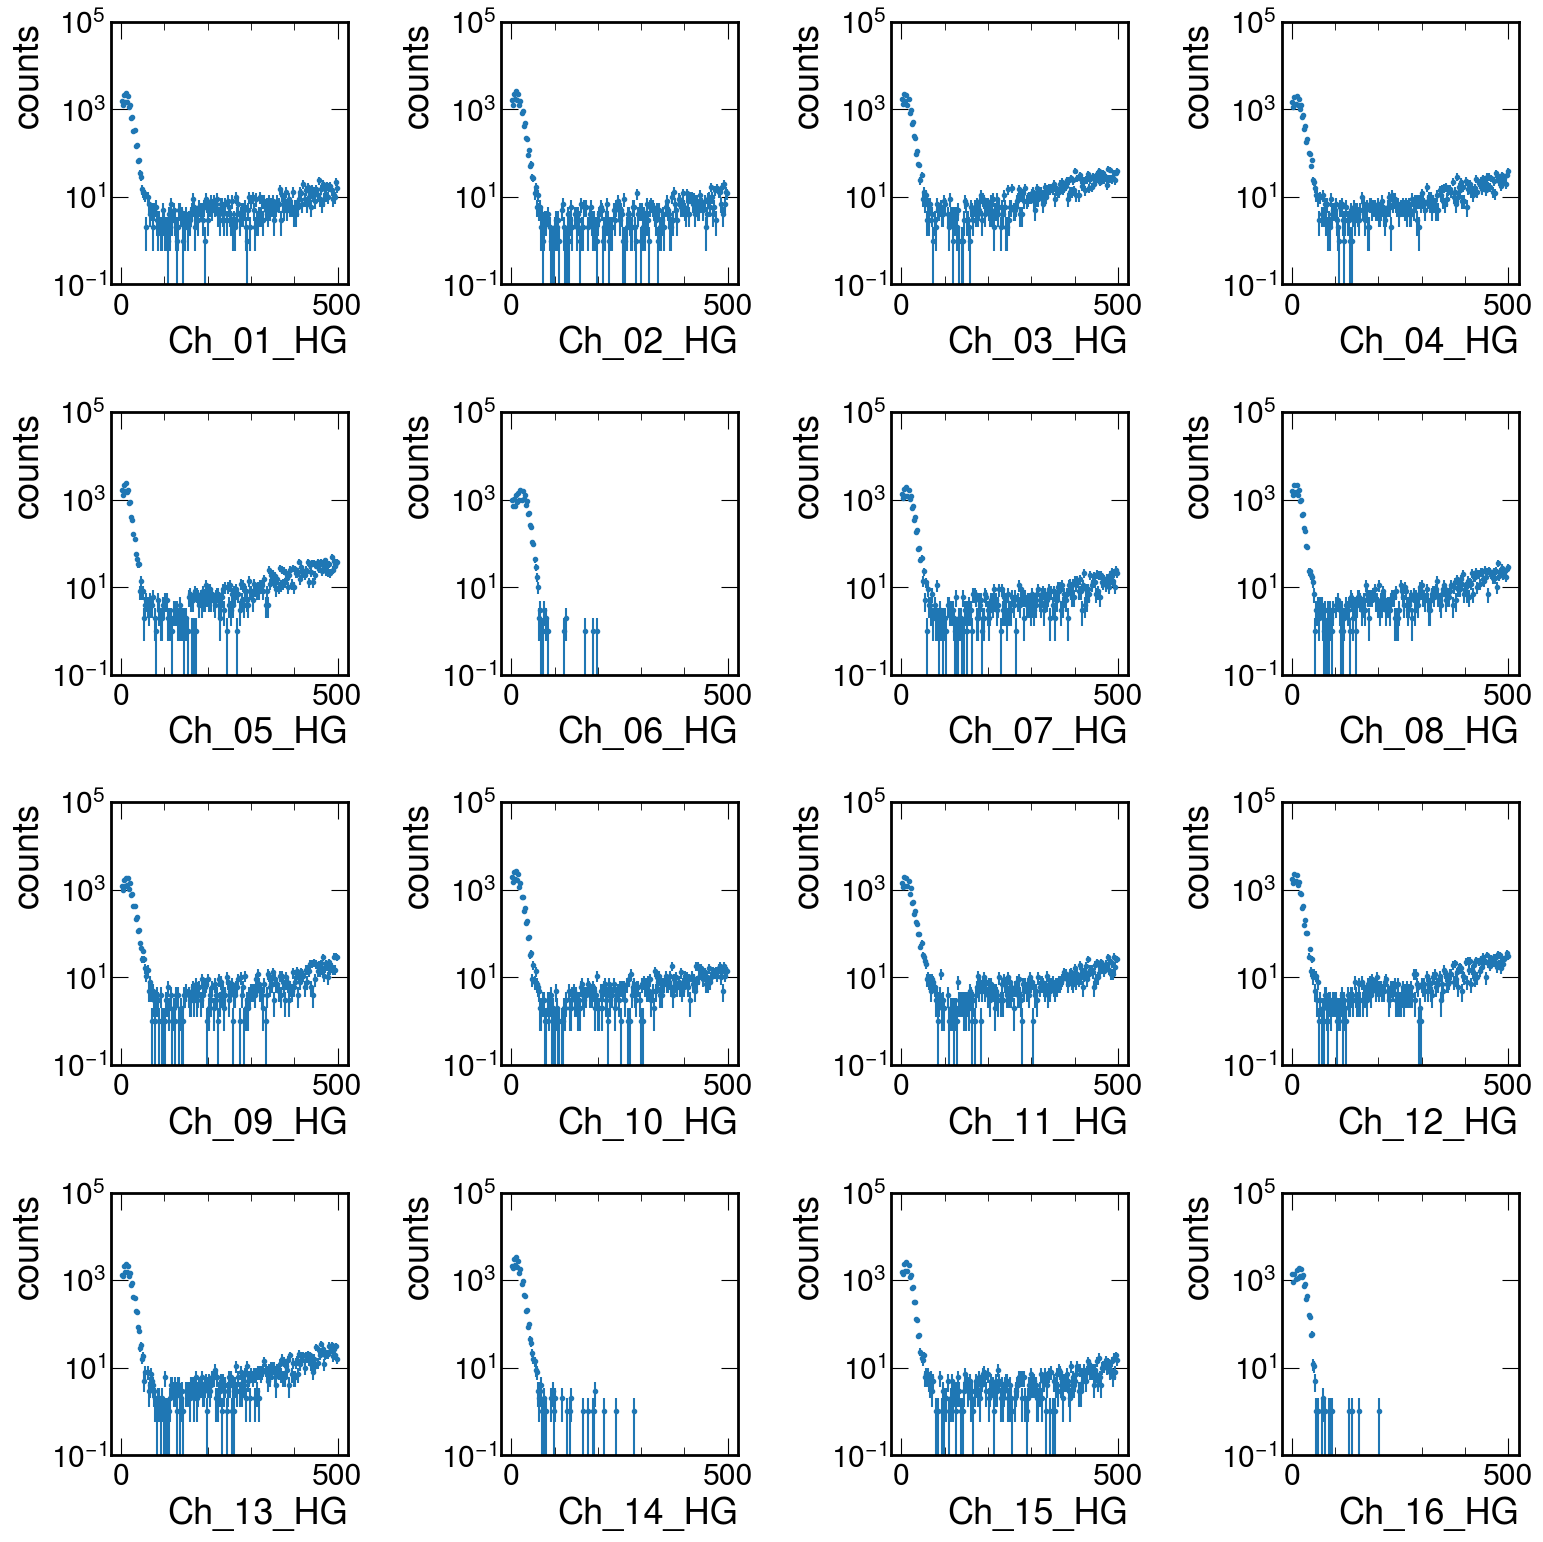

In [142]:
gain="HG"
fig, axs=plt.subplots(4,4, figsize=(16, 16))
for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    hist,x,= np.histogram(df.eval(f"Ch_{ch}_{gain}"), bins=100 if gain== "LG" else 200, 
                          range=(0,100) if gain == "LG" else (0, 500))
    plt.xlabel(f"Ch_{ch}_{gain}")
    plt.ylabel("counts")

    bin_centers=(x[1:]+x[:-1])/2

    from scipy.optimize import curve_fit
    if gain=="LG":
        start,stop=int(20/(x[1]-x[0])),None
    else :
        start,stop=int(100/(x[1]-x[0])),None
    p0=[1000, 30, 10]

    plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data', markersize=3)
    plt.yscale("log")
    plt.ylim(0.1, 1e5)
plt.tight_layout()


3984.0 8.172172682190878
3982.0 8.1811786473551
3943.0 8.290117864043609
4027.0 8.09821073501326
3983.0 8.19376631283021
188.0 174.18797426863284
4012.0 8.069938243521861
3982.0 8.161833856557662
3988.0 8.164519591287043
4011.0 8.154560193820826


/var/folders/_x/mzz2_hcx0dg4mv6b9blzjpp40000gn/T/ipykernel_32865/2167231010.py:20: RuntimeWarning: invalid value encountered in double_scalars
  m=(np.sum(xf*yf)*len(xf)-np.sum(xf)*np.sum(yf))/(np.sum(xf*xf)*len(xf)-np.sum(xf)*np.sum(xf))


3992.0 8.163694331046576
4004.0 8.15953235045454
3950.0 8.241432293467986
177.0 184.42717818822933
4006.0 8.121460950293399
139.0 235.5767172416967


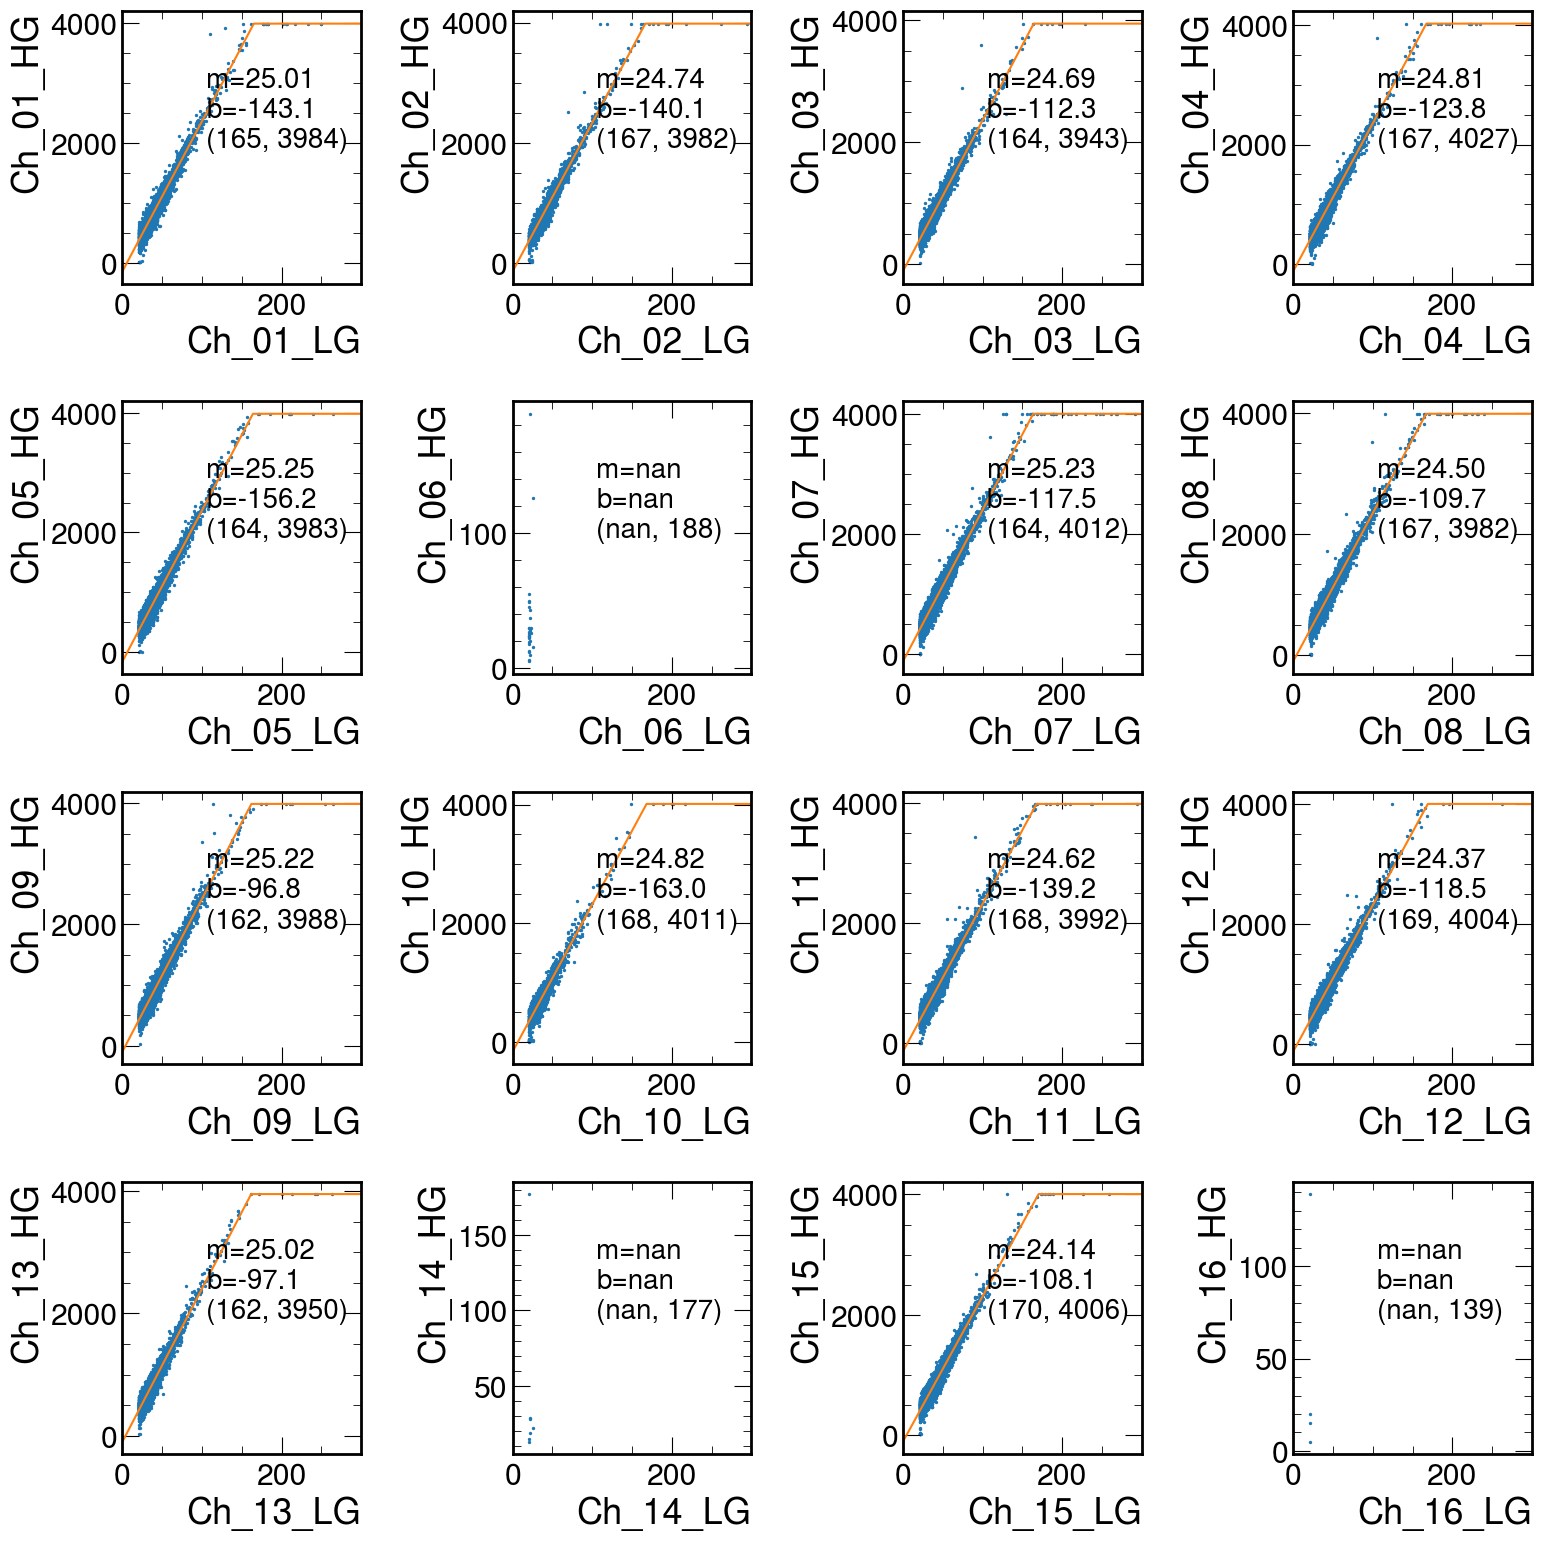

In [147]:
fig, axs=plt.subplots(4,4, figsize=(16, 16))

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    
    q= f"Ch_{ch}_LG>20 and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    plt.scatter(df.query(q).eval(f"Ch_{ch}_LG"), df.query(q).eval(f"Ch_{ch}_HG"),s=2)
    plt.xlabel(f"Ch_{ch}_LG")
    plt.ylabel(f"Ch_{ch}_HG")
    
    q=f"Ch_{ch}_LG>20 and Ch_{ch}_HG>100 and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    x,= df.query(q).eval(f"Ch_{ch}_LG"), 
    y = df.query(q).eval(f"Ch_{ch}_HG")
    print(max(y), np.mean(df.query(f"Ch_{ch}_HG>{0.95*max(y)}").eval(f"Ch_{ch}_HG"))/max(y))
    
    q= f"Ch_{ch}_HG<{max(y)} and Ch_{ch}_LG>20 and Ch_{ch}_HG>100 and Ch_{ch}_HG<5000 and Ch_{ch}_LG<1000"
    xf= df.query(q).eval(f"Ch_{ch}_LG")
    yf= df.query(q).eval(f"Ch_{ch}_HG")
    m=(np.sum(xf*yf)*len(xf)-np.sum(xf)*np.sum(yf))/(np.sum(xf*xf)*len(xf)-np.sum(xf)*np.sum(xf))
    b = (sum(yf)-m*sum(xf))/len(xf)
    xelbow=(max(y)-b)/m
    yelbow=max(y)
    plt.plot([0, xelbow, max(df.eval(f"Ch_{ch}_LG"))], [b, yelbow, yelbow], linestyle='-', color='tab:orange')
    plt.text(0.35, 0.5, f"m={m:.2f}\nb={b:.1f}\n({xelbow:.0f}, {yelbow:.0f})", transform=plt.gca().transAxes, fontsize=20)
    plt.xlim(0, 300)
plt.tight_layout()

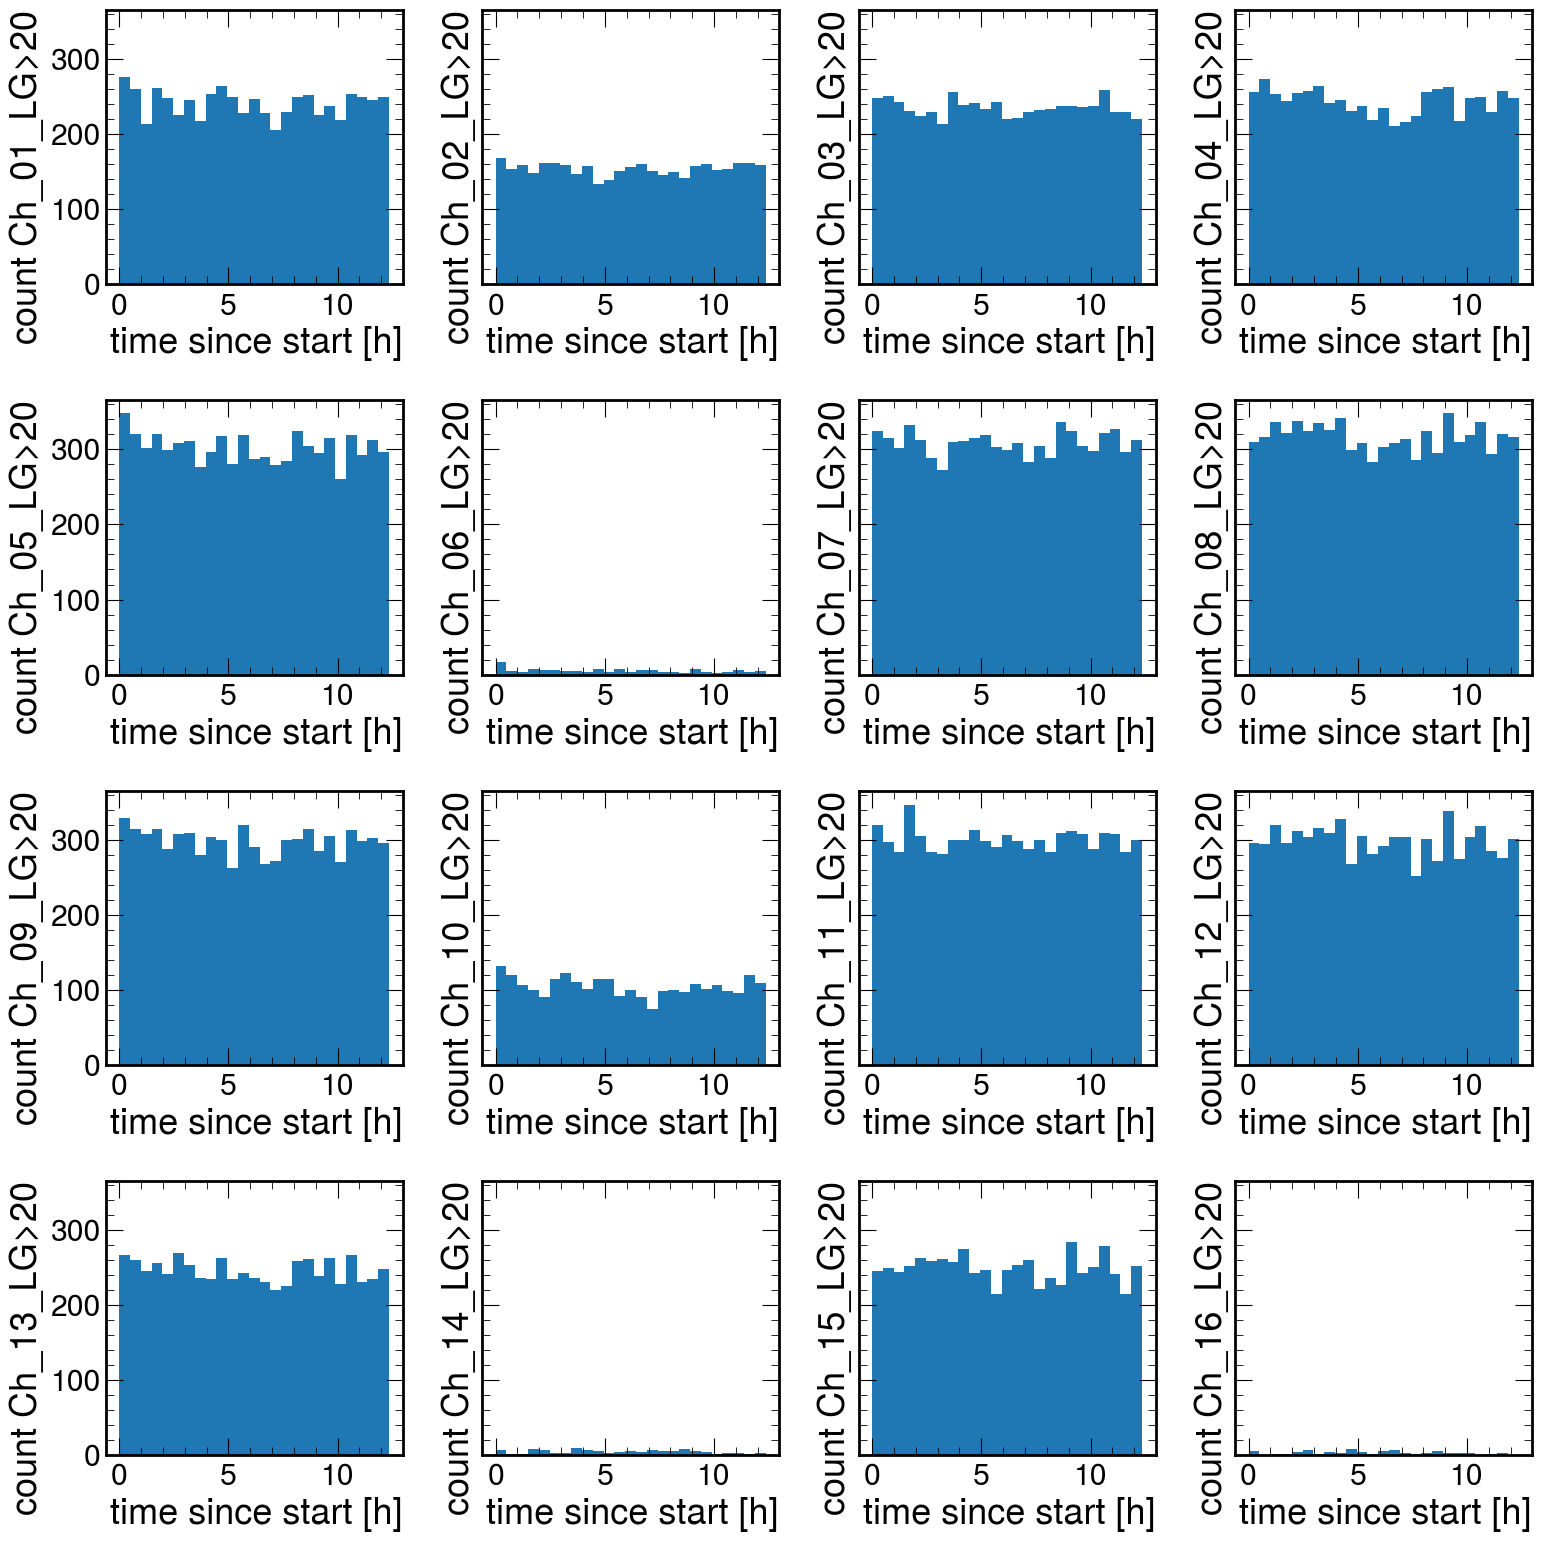

In [150]:
fig, axs=plt.subplots(4,4, figsize=(16, 16),sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    plt.hist(df.query(f"Ch_{ch}_LG>20").eval(f"timestamp/3.6e9"), bins=25, range=(0,max(df.timestamp)/3.6e9))
    plt.xlabel(f"time since start [h]")
    plt.ylabel(f"count Ch_{ch}_LG>20")
plt.tight_layout()

0 0
chi2= 8.296881308370827 ndof= 21 pval= 0.9937520217834165
0 1
0 2
0 3
0 4
0 5
chi2= 19.9564174059496 ndof= 21 pval= 0.5240233225265349
0 6
0 7
chi2= 11.488712338966176 ndof= 21 pval= 0.9524046351046366
0 8
0 9
1 0
1 1
chi2= 18.438308169826524 ndof= 21 pval= 0.6211231820794024
1 2
chi2= 9.136018289807128 ndof= 21 pval= 0.988102882681059
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
chi2= 25.828465674799364 ndof= 21 pval= 0.21306529155064216
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 1
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 2
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 3
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 4
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 5
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 6
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 7
chi2= 4.0257832874684456e-41 ndof= 21 pval= 1.0
5 8
chi2= 4.0257832874684456e-41 n

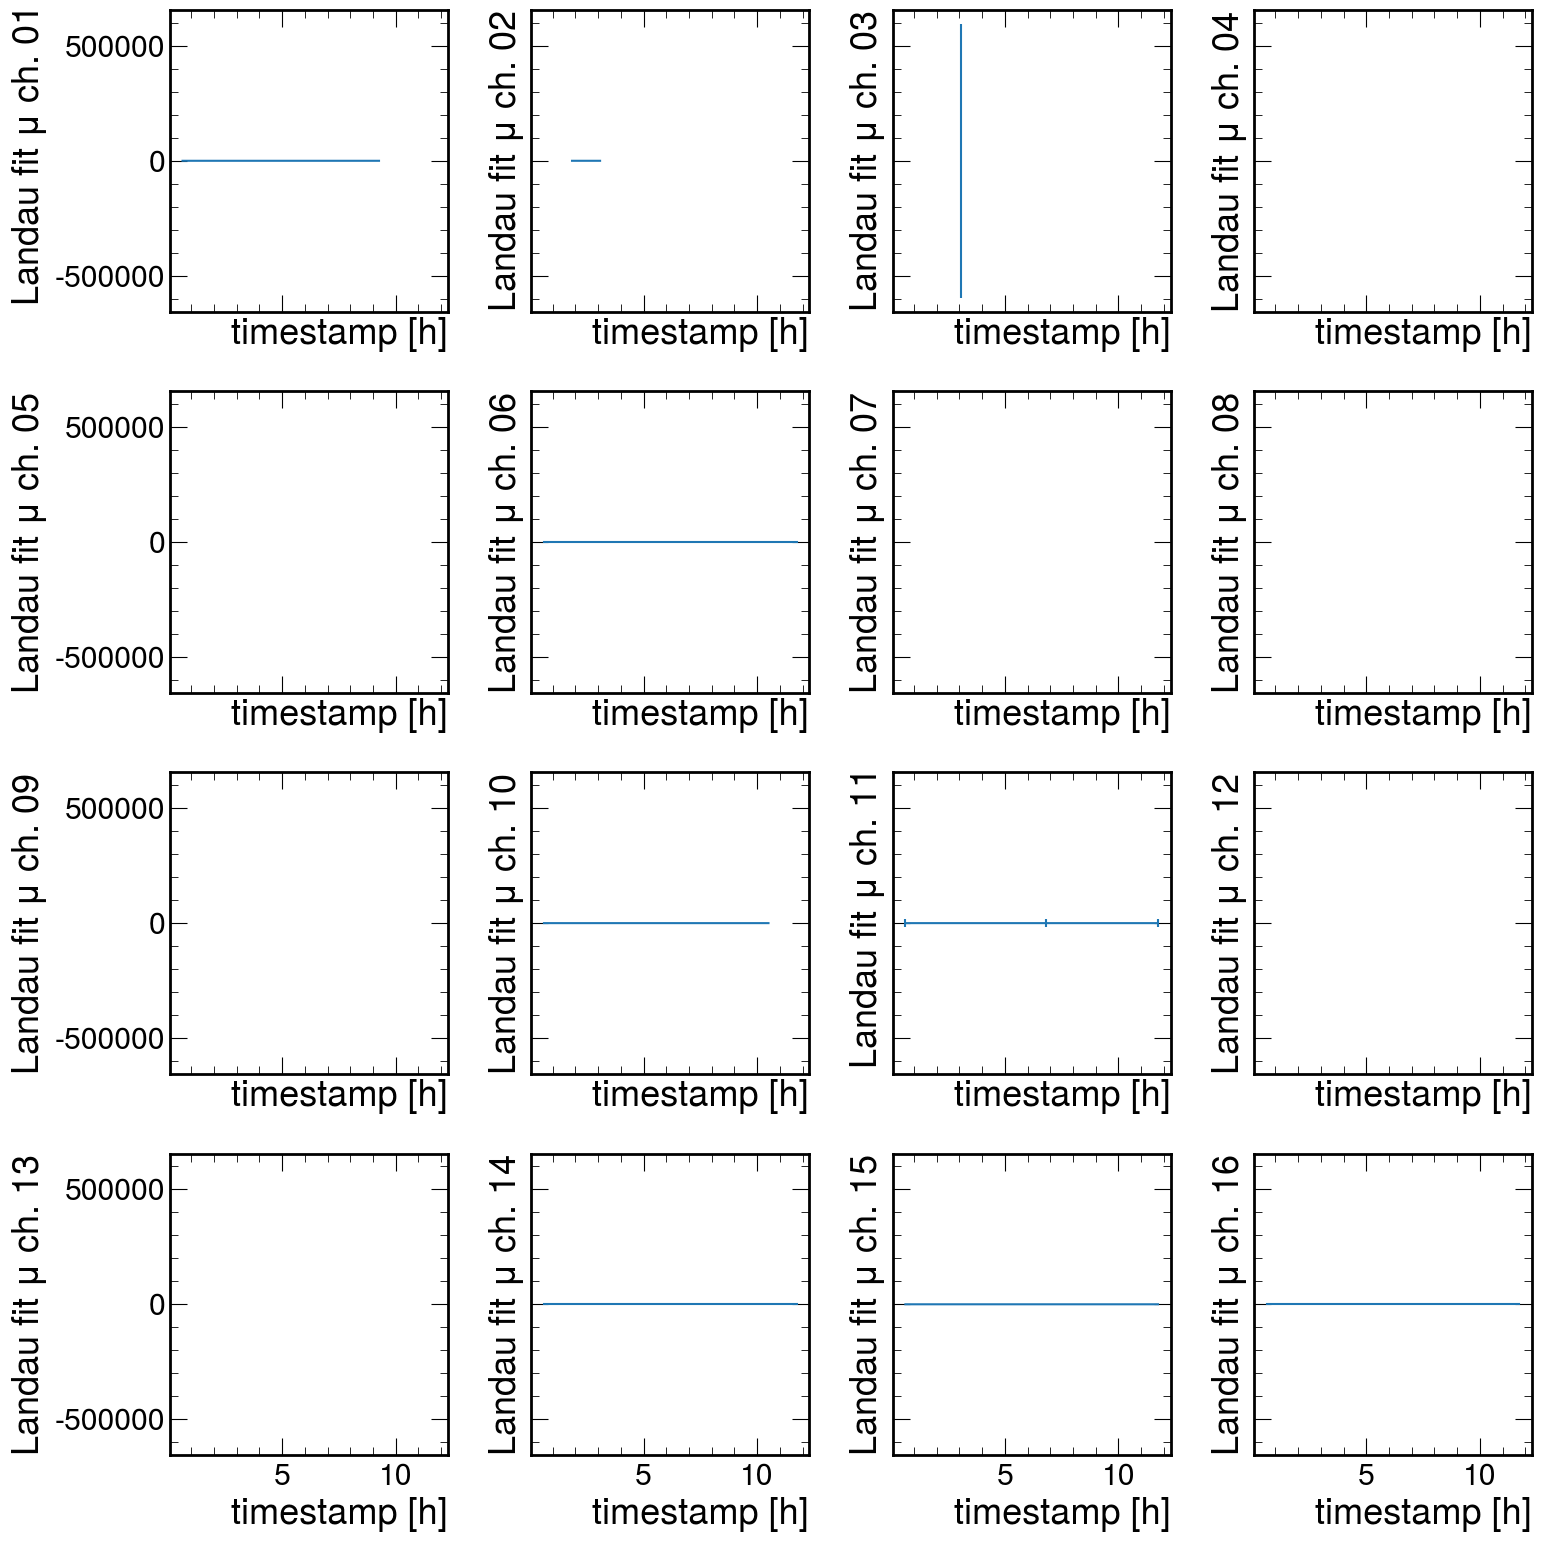

In [156]:
fig, axs=plt.subplots(4,4, figsize=(16, 16),sharex='all', sharey='all')

for i in range(len(channels)):
    ch = channels[i]
    plt.sca(axs[i//4][i%4])
    slices = np.linspace(min(df.timestamp), max(df.timestamp), 11)
    mus=[]
    dmus=[]
    centers=[]
    for j in range(len(slices)-1):
        try:
            hist,x,= np.histogram(df.query(f"timestamp>{slices[j]} and timestamp<{slices[j+1]}")\
                                  .eval(f"Ch_{ch}_LG"), bins=26, range=(20,200))


            bin_centers=(x[1:]+x[:-1])/2

            from scipy.optimize import curve_fit
            start,stop=int(20/(x[1]-x[0])),None
            p0=[1000, 30, 10]

            #plt.errorbar(bin_centers, hist, np.sqrt(hist), linestyle='', marker='o', label='data')

            dhist=np.sqrt(hist[start:stop])+(hist[start:stop]==0)
            print(i,j)
            coeff, var_matrix = curve_fit(Landau, bin_centers[start:stop], hist[start:stop], p0=p0,
                                     sigma=dhist)
            from scipy.stats import chi2
            chi2val = sum((Landau(bin_centers[start:stop], *coeff)-hist[start:stop])**2/dhist**2)
            ndof = len(bin_centers[start:stop])-len(coeff)
            print("chi2=",chi2val, "ndof=",ndof, "pval=", chi2.sf(chi2val, ndof))
            x=np.linspace(0, 140, 280)
            mu=coeff[1]
            dmu=np.sqrt(var_matrix[1][1])
            mus.append(mu)
            dmus.append(dmu)
            centers.append((slices[j]+slices[j+1])/2)
        except RuntimeError:
            pass
            
    plt.errorbar(np.array(centers)/(3.6e9), mus, dmu)
    plt.xlabel(f"timestamp [h]")
    plt.ylabel(f"Landau fit $\mu$ ch. {ch}")
    
plt.tight_layout()